In [1]:
"""
Train a simple deep CNN on the CIFAR10 small images dataset.
But in black and white.
"""
# Python Libraries
import os
import time

# 3rd Party Libraries
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


print(tf.__version__)
print(tf.keras.__version__)
tf.test.gpu_device_name()


1.12.0
2.1.6-tf


'/device:GPU:0'

In [2]:
batch_size = 32
num_classes = 10
epochs = 100
num_predictions = 20
cifar10_filepath = r'/home/share/dataset/cifar10'
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'


train_in shape: (37500, 32, 32, 3)
37500 train samples
12500 validation samples
b'airplane'
b'cat'


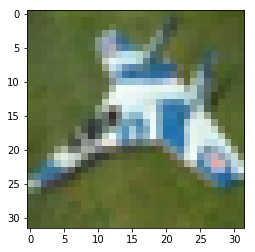

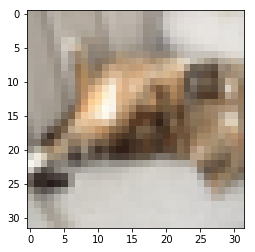

In [3]:
from tensorflow.keras.utils import to_categorical

class CIFAR10(object):
    def __init__(self, folder):
        """
        Initializes the CIFAR10 class
        :param folder: 
        """
        self.folder = folder
        self._init_dataset()

    @staticmethod
    def _unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            d = pickle.load(fo, encoding='bytes')
        return d
    
    def _init_dataset(self):
        """
        Internal member function that reads a CIFAR-10 dataset
        Data and Meta Batches from disk        
        :return: N/A 
        """
        self.db = []
        self.db.append(
            self._unpickle(os.path.join(self.folder, 'data_batch_1')))
        self.db.append(
            self._unpickle(os.path.join(self.folder, 'data_batch_2')))
        self.db.append(
            self._unpickle(os.path.join(self.folder, 'data_batch_3')))
        self.db.append(
            self._unpickle(os.path.join(self.folder, 'data_batch_4')))
        self.db.append(
            self._unpickle(os.path.join(self.folder, 'data_batch_5')))
        self.tb = self._unpickle(os.path.join(self.folder, 'test_batch'))
        self.bm = self._unpickle(os.path.join(self.folder, 'batches.meta'))
    
    def validation_split(self, test_size):
        """
        Returns the training and validation splits from training data
        :param train_size:  a float representing the % of the data to use for
                            training (the rest for validation)  
        :return:    a tuple with the training data, validation data,
                    training labels, and validation labels
        """
        seed = int(time.time())
        for batch in self.db:
            try:
                train = np.vstack((train, batch[b'data']))
            except NameError:
                train = batch[b'data']
            try:
                output = np.hstack((output, np.array(batch[b'labels'])))
            except NameError:
                output = np.array(batch[b'labels'])
        train = np.reshape(train, (train.shape[0], 32, 32, 3), order='F')
        train = np.swapaxes(train, 1, 2)    # swap x and y axis
        return train_test_split(
            train,
            output,
            test_size=test_size,
            random_state=seed)
    
    def test_data(self):
        """
        Returns test data in a (train, label) tuple
        :return: (train, label) tuple
        """
        test = self.tb[b'data']
        test = np.reshape(test, (test.shape[0], 32, 32, 3), order='F')
        test = np.swapaxes(test, 1, 2)
        output = self.tb[b'labels']
        return test, output
    
    @property
    def label_names(self):
        """
        Returns the label names for human readable label names
        :return: a list containing the human readable label names for each class
        """
        return self.bm[b'label_names']
    @label_names.setter
    def label_names(self, value):
        raise NotImplementedError

   
dataset = CIFAR10(folder=cifar10_filepath)
train_in, val_in, train_out, val_out = dataset.validation_split(0.25)

print('train_in shape:', train_in.shape)
print(train_in.shape[0], 'train samples')
print(val_in.shape[0], 'validation samples')

# Convert class vectors to binary class matrices.
# AKA One hot encoding
train_out_cat = to_categorical(train_out, num_classes)
val_out_cat = to_categorical(val_out, num_classes)

# Show one of the images to check data format
plt.figure(1)
plt.imshow(train_in[0])
print(dataset.label_names[train_out[0]])
plt.figure(2)
plt.imshow(train_in[1])
print(dataset.label_names[train_out[1]])


In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense 

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_in.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [5]:
from tensorflow.keras.optimizers import RMSprop
# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



In [6]:
train_in = train_in.astype('float32')
val_in = val_in.astype('float32')
train_in /= 255
val_in /= 255

# NOTE: In Manjaro Linux, it seems you can't suspend without corrupting
# the GPU initialization. Try avoid 
model.fit(train_in, train_out_cat,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_in, val_out_cat),
          shuffle=True)


Train on 37500 samples, validate on 12500 samples
Epoch 1/100


   32/37500 [..............................] - ETA: 12:15 - loss: 2.3218 - acc: 0.0938

  384/37500 [..............................] - ETA: 1:05 - loss: 2.3069 - acc: 0.0964 

  736/37500 [..............................] - ETA: 36s - loss: 2.3102 - acc: 0.1033 

 1088/37500 [..............................] - ETA: 26s - loss: 2.3025 - acc: 0.1241

 1472/37500 [>.............................] - ETA: 20s - loss: 2.3020 - acc: 0.1189

 1856/37500 [>.............................] - ETA: 17s - loss: 2.3000 - acc: 0.1261

 2240/37500 [>.............................] - ETA: 14s - loss: 2.2946 - acc: 0.1299

 2624/37500 [=>............................] - ETA: 13s - loss: 2.2901 - acc: 0.1315

 3008/37500 [=>............................] - ETA: 12s - loss: 2.2862 - acc: 0.1350

 3392/37500 [=>............................] - ETA: 11s - loss: 2.2796 - acc: 0.1365

 3776/37500 [==>...........................] - ETA: 10s - loss: 2.2722 - acc: 0.1443

 4160/37500 [==>...........................] - ETA: 9s - loss: 2.2652 - acc: 0.1490 

 4544/37500 [==>...........................] - ETA: 9s - loss: 2.2566 - acc: 0.1510

 4896/37500 [==>...........................] - ETA: 8s - loss: 2.2491 - acc: 0.1534

 5280/37500 [===>..........................] - ETA: 8s - loss: 2.2388 - acc: 0.1578

 5664/37500 [===>..........................] - ETA: 7s - loss: 2.2325 - acc: 0.1623

 6048/37500 [===>..........................] - ETA: 7s - loss: 2.2212 - acc: 0.1675

 6464/37500 [====>.........................] - ETA: 7s - loss: 2.2151 - acc: 0.1717

 6848/37500 [====>.........................] - ETA: 7s - loss: 2.2056 - acc: 0.1763

 7264/37500 [====>.........................] - ETA: 6s - loss: 2.1967 - acc: 0.1821

 7648/37500 [=====>........................] - ETA: 6s - loss: 2.1866 - acc: 0.1858

 8064/37500 [=====>........................] - ETA: 6s - loss: 2.1803 - acc: 0.1877

 8448/37500 [=====>........................] - ETA: 6s - loss: 2.1749 - acc: 0.1903

 8864/37500 [======>.......................] - ETA: 5s - loss: 2.1689 - acc: 0.1934

 9248/37500 [======>.......................] - ETA: 5s - loss: 2.1631 - acc: 0.1958

 9632/37500 [======>.......................] - ETA: 5s - loss: 2.1571 - acc: 0.1980

10016/37500 [=======>......................] - ETA: 5s - loss: 2.1534 - acc: 0.1992

10400/37500 [=======>......................] - ETA: 5s - loss: 2.1481 - acc: 0.2024

10784/37500 [=======>......................] - ETA: 5s - loss: 2.1442 - acc: 0.2036

11168/37500 [=======>......................] - ETA: 5s - loss: 2.1404 - acc: 0.2050

11552/37500 [========>.....................] - ETA: 4s - loss: 2.1367 - acc: 0.2076

11936/37500 [========>.....................] - ETA: 4s - loss: 2.1309 - acc: 0.2101

12320/37500 [========>.....................] - ETA: 4s - loss: 2.1260 - acc: 0.2123

12704/37500 [=========>....................] - ETA: 4s - loss: 2.1226 - acc: 0.2136

13088/37500 [=========>....................] - ETA: 4s - loss: 2.1183 - acc: 0.2151

13472/37500 [=========>....................] - ETA: 4s - loss: 2.1139 - acc: 0.2173

13856/37500 [==========>...................] - ETA: 4s - loss: 2.1087 - acc: 0.2208

14240/37500 [==========>...................] - ETA: 4s - loss: 2.1051 - acc: 0.2228

14624/37500 [==========>...................] - ETA: 4s - loss: 2.1004 - acc: 0.2246

15008/37500 [===========>..................] - ETA: 3s - loss: 2.0952 - acc: 0.2273

15392/37500 [===========>..................] - ETA: 3s - loss: 2.0909 - acc: 0.2286

15776/37500 [===========>..................] - ETA: 3s - loss: 2.0869 - acc: 0.2299

16160/37500 [===========>..................] - ETA: 3s - loss: 2.0824 - acc: 0.2317

16544/37500 [============>.................] - ETA: 3s - loss: 2.0774 - acc: 0.2343

16928/37500 [============>.................] - ETA: 3s - loss: 2.0728 - acc: 0.2355

17280/37500 [============>.................] - ETA: 3s - loss: 2.0695 - acc: 0.2365

17664/37500 [=============>................] - ETA: 3s - loss: 2.0648 - acc: 0.2375

18048/37500 [=============>................] - ETA: 3s - loss: 2.0605 - acc: 0.2390

18432/37500 [=============>................] - ETA: 3s - loss: 2.0565 - acc: 0.2398

18816/37500 [==============>...............] - ETA: 3s - loss: 2.0512 - acc: 0.2419

19200/37500 [==============>...............] - ETA: 3s - loss: 2.0468 - acc: 0.2437

19584/37500 [==============>...............] - ETA: 2s - loss: 2.0436 - acc: 0.2453

19968/37500 [==============>...............] - ETA: 2s - loss: 2.0388 - acc: 0.2474

20352/37500 [===============>..............] - ETA: 2s - loss: 2.0350 - acc: 0.2493

20736/37500 [===============>..............] - ETA: 2s - loss: 2.0316 - acc: 0.2503

21120/37500 [===============>..............] - ETA: 2s - loss: 2.0278 - acc: 0.2519

21504/37500 [================>.............] - ETA: 2s - loss: 2.0235 - acc: 0.2538

21888/37500 [================>.............] - ETA: 2s - loss: 2.0209 - acc: 0.2546

22272/37500 [================>.............] - ETA: 2s - loss: 2.0159 - acc: 0.2565

22656/37500 [=================>............] - ETA: 2s - loss: 2.0120 - acc: 0.2582

23040/37500 [=================>............] - ETA: 2s - loss: 2.0080 - acc: 0.2600

23424/37500 [=================>............] - ETA: 2s - loss: 2.0061 - acc: 0.2607

23808/37500 [==================>...........] - ETA: 2s - loss: 2.0016 - acc: 0.2623

24192/37500 [==================>...........] - ETA: 2s - loss: 1.9977 - acc: 0.2634

24576/37500 [==================>...........] - ETA: 2s - loss: 1.9948 - acc: 0.2641

24960/37500 [==================>...........] - ETA: 2s - loss: 1.9919 - acc: 0.2649

25344/37500 [===================>..........] - ETA: 1s - loss: 1.9886 - acc: 0.2659

25728/37500 [===================>..........] - ETA: 1s - loss: 1.9850 - acc: 0.2676

26112/37500 [===================>..........] - ETA: 1s - loss: 1.9821 - acc: 0.2691

26496/37500 [====================>.........] - ETA: 1s - loss: 1.9790 - acc: 0.2705

26880/37500 [====================>.........] - ETA: 1s - loss: 1.9762 - acc: 0.2719

27264/37500 [====================>.........] - ETA: 1s - loss: 1.9736 - acc: 0.2727

27648/37500 [=====================>........] - ETA: 1s - loss: 1.9715 - acc: 0.2737

28032/37500 [=====================>........] - ETA: 1s - loss: 1.9692 - acc: 0.2748

28416/37500 [=====================>........] - ETA: 1s - loss: 1.9653 - acc: 0.2762

28800/37500 [======================>.......] - ETA: 1s - loss: 1.9623 - acc: 0.2773

29184/37500 [======================>.......] - ETA: 1s - loss: 1.9593 - acc: 0.2789

29568/37500 [======================>.......] - ETA: 1s - loss: 1.9563 - acc: 0.2803

29952/37500 [======================>.......] - ETA: 1s - loss: 1.9539 - acc: 0.2811

30336/37500 [=======================>......] - ETA: 1s - loss: 1.9519 - acc: 0.2819

30720/37500 [=======================>......] - ETA: 1s - loss: 1.9500 - acc: 0.2826

31104/37500 [=======================>......] - ETA: 0s - loss: 1.9469 - acc: 0.2839

31488/37500 [========================>.....] - ETA: 0s - loss: 1.9453 - acc: 0.2847

31872/37500 [========================>.....] - ETA: 0s - loss: 1.9422 - acc: 0.2856

32256/37500 [========================>.....] - ETA: 0s - loss: 1.9402 - acc: 0.2863

32640/37500 [=========================>....] - ETA: 0s - loss: 1.9377 - acc: 0.2873

33024/37500 [=========================>....] - ETA: 0s - loss: 1.9349 - acc: 0.2886

33408/37500 [=========================>....] - ETA: 0s - loss: 1.9323 - acc: 0.2899

33824/37500 [==========================>...] - ETA: 0s - loss: 1.9293 - acc: 0.2912

34208/37500 [==========================>...] - ETA: 0s - loss: 1.9259 - acc: 0.2928

34624/37500 [==========================>...] - ETA: 0s - loss: 1.9233 - acc: 0.2940

35008/37500 [===========================>..] - ETA: 0s - loss: 1.9202 - acc: 0.2956

35392/37500 [===========================>..] - ETA: 0s - loss: 1.9179 - acc: 0.2969

35776/37500 [===========================>..] - ETA: 0s - loss: 1.9164 - acc: 0.2976

36160/37500 [===========================>..] - ETA: 0s - loss: 1.9141 - acc: 0.2985

36544/37500 [============================>.] - ETA: 0s - loss: 1.9111 - acc: 0.2995

36928/37500 [============================>.] - ETA: 0s - loss: 1.9092 - acc: 0.3004

37312/37500 [============================>.] - ETA: 0s - loss: 1.9078 - acc: 0.3011

37500/37500 [==============================] - 6s 166us/step - loss: 1.9066 - acc: 0.3015 - val_loss: 1.6153 - val_acc: 0.4181


Epoch 2/100
   32/37500 [..............................] - ETA: 9s - loss: 1.7253 - acc: 0.3750

  384/37500 [..............................] - ETA: 5s - loss: 1.6968 - acc: 0.3828

  768/37500 [..............................] - ETA: 5s - loss: 1.6967 - acc: 0.3776

 1152/37500 [..............................] - ETA: 5s - loss: 1.7006 - acc: 0.3715

 1504/37500 [>.............................] - ETA: 5s - loss: 1.7085 - acc: 0.3690

 1888/37500 [>.............................] - ETA: 5s - loss: 1.7123 - acc: 0.3686

 2272/37500 [>.............................] - ETA: 4s - loss: 1.6998 - acc: 0.3750

 2656/37500 [=>............................] - ETA: 4s - loss: 1.7030 - acc: 0.3765

 3040/37500 [=>............................] - ETA: 4s - loss: 1.7044 - acc: 0.3773

 3424/37500 [=>............................] - ETA: 4s - loss: 1.7025 - acc: 0.3762

 3808/37500 [==>...........................] - ETA: 4s - loss: 1.6998 - acc: 0.3782

 4192/37500 [==>...........................] - ETA: 4s - loss: 1.6917 - acc: 0.3814

 4576/37500 [==>...........................] - ETA: 4s - loss: 1.6890 - acc: 0.3820

 4960/37500 [==>...........................] - ETA: 4s - loss: 1.6771 - acc: 0.3869

 5344/37500 [===>..........................] - ETA: 4s - loss: 1.6746 - acc: 0.3890

 5728/37500 [===>..........................] - ETA: 4s - loss: 1.6719 - acc: 0.3907

 6112/37500 [===>..........................] - ETA: 4s - loss: 1.6657 - acc: 0.3940

 6496/37500 [====>.........................] - ETA: 4s - loss: 1.6652 - acc: 0.3939

 6880/37500 [====>.........................] - ETA: 4s - loss: 1.6642 - acc: 0.3953

 7264/37500 [====>.........................] - ETA: 4s - loss: 1.6610 - acc: 0.3974

 7648/37500 [=====>........................] - ETA: 4s - loss: 1.6625 - acc: 0.3970

 8032/37500 [=====>........................] - ETA: 3s - loss: 1.6628 - acc: 0.3973

 8384/37500 [=====>........................] - ETA: 3s - loss: 1.6638 - acc: 0.3973

 8768/37500 [======>.......................] - ETA: 3s - loss: 1.6636 - acc: 0.3976

 9120/37500 [======>.......................] - ETA: 3s - loss: 1.6622 - acc: 0.3986

 9504/37500 [======>.......................] - ETA: 3s - loss: 1.6629 - acc: 0.4003

 9888/37500 [======>.......................] - ETA: 3s - loss: 1.6622 - acc: 0.4007

10272/37500 [=======>......................] - ETA: 3s - loss: 1.6619 - acc: 0.4012

10592/37500 [=======>......................] - ETA: 3s - loss: 1.6578 - acc: 0.4031

10976/37500 [=======>......................] - ETA: 3s - loss: 1.6539 - acc: 0.4042

11360/37500 [========>.....................] - ETA: 3s - loss: 1.6526 - acc: 0.4049

11744/37500 [========>.....................] - ETA: 3s - loss: 1.6495 - acc: 0.4063

12096/37500 [========>.....................] - ETA: 3s - loss: 1.6492 - acc: 0.4062

12448/37500 [========>.....................] - ETA: 3s - loss: 1.6483 - acc: 0.4062

12832/37500 [=========>....................] - ETA: 3s - loss: 1.6464 - acc: 0.4075

13216/37500 [=========>....................] - ETA: 3s - loss: 1.6452 - acc: 0.4076

13600/37500 [=========>....................] - ETA: 3s - loss: 1.6427 - acc: 0.4082

13952/37500 [==========>...................] - ETA: 3s - loss: 1.6408 - acc: 0.4083

14304/37500 [==========>...................] - ETA: 3s - loss: 1.6388 - acc: 0.4090

14688/37500 [==========>...................] - ETA: 3s - loss: 1.6383 - acc: 0.4095

15072/37500 [===========>..................] - ETA: 3s - loss: 1.6378 - acc: 0.4093

15456/37500 [===========>..................] - ETA: 3s - loss: 1.6381 - acc: 0.4095

15840/37500 [===========>..................] - ETA: 2s - loss: 1.6386 - acc: 0.4097

16224/37500 [===========>..................] - ETA: 2s - loss: 1.6374 - acc: 0.4099

16608/37500 [============>.................] - ETA: 2s - loss: 1.6369 - acc: 0.4097

16960/37500 [============>.................] - ETA: 2s - loss: 1.6359 - acc: 0.4101

17344/37500 [============>.................] - ETA: 2s - loss: 1.6351 - acc: 0.4107

17728/37500 [=============>................] - ETA: 2s - loss: 1.6348 - acc: 0.4105

18112/37500 [=============>................] - ETA: 2s - loss: 1.6331 - acc: 0.4100

18496/37500 [=============>................] - ETA: 2s - loss: 1.6332 - acc: 0.4095

18880/37500 [==============>...............] - ETA: 2s - loss: 1.6334 - acc: 0.4088

19264/37500 [==============>...............] - ETA: 2s - loss: 1.6319 - acc: 0.4084

19648/37500 [==============>...............] - ETA: 2s - loss: 1.6308 - acc: 0.4089

20032/37500 [===============>..............] - ETA: 2s - loss: 1.6291 - acc: 0.4087

20416/37500 [===============>..............] - ETA: 2s - loss: 1.6288 - acc: 0.4092

20736/37500 [===============>..............] - ETA: 2s - loss: 1.6260 - acc: 0.4097

21056/37500 [===============>..............] - ETA: 2s - loss: 1.6251 - acc: 0.4106

21408/37500 [================>.............] - ETA: 2s - loss: 1.6246 - acc: 0.4106

21760/37500 [================>.............] - ETA: 2s - loss: 1.6250 - acc: 0.4107

22080/37500 [================>.............] - ETA: 2s - loss: 1.6237 - acc: 0.4111

22400/37500 [================>.............] - ETA: 2s - loss: 1.6226 - acc: 0.4122

22720/37500 [=================>............] - ETA: 2s - loss: 1.6226 - acc: 0.4119

23008/37500 [=================>............] - ETA: 2s - loss: 1.6211 - acc: 0.4128

23328/37500 [=================>............] - ETA: 1s - loss: 1.6207 - acc: 0.4129

23648/37500 [=================>............] - ETA: 1s - loss: 1.6196 - acc: 0.4135

24000/37500 [==================>...........] - ETA: 1s - loss: 1.6193 - acc: 0.4137

24352/37500 [==================>...........] - ETA: 1s - loss: 1.6188 - acc: 0.4140

24736/37500 [==================>...........] - ETA: 1s - loss: 1.6184 - acc: 0.4141

25120/37500 [===================>..........] - ETA: 1s - loss: 1.6178 - acc: 0.4138

25504/37500 [===================>..........] - ETA: 1s - loss: 1.6180 - acc: 0.4135

25888/37500 [===================>..........] - ETA: 1s - loss: 1.6178 - acc: 0.4136

26272/37500 [====================>.........] - ETA: 1s - loss: 1.6169 - acc: 0.4142

26656/37500 [====================>.........] - ETA: 1s - loss: 1.6152 - acc: 0.4149

27040/37500 [====================>.........] - ETA: 1s - loss: 1.6157 - acc: 0.4147

27424/37500 [====================>.........] - ETA: 1s - loss: 1.6155 - acc: 0.4145

27808/37500 [=====================>........] - ETA: 1s - loss: 1.6146 - acc: 0.4143

28192/37500 [=====================>........] - ETA: 1s - loss: 1.6136 - acc: 0.4142

28576/37500 [=====================>........] - ETA: 1s - loss: 1.6128 - acc: 0.4148

28992/37500 [======================>.......] - ETA: 1s - loss: 1.6109 - acc: 0.4154

29376/37500 [======================>.......] - ETA: 1s - loss: 1.6106 - acc: 0.4155

29792/37500 [======================>.......] - ETA: 1s - loss: 1.6090 - acc: 0.4165

30176/37500 [=======================>......] - ETA: 1s - loss: 1.6086 - acc: 0.4170

30560/37500 [=======================>......] - ETA: 0s - loss: 1.6073 - acc: 0.4175

30944/37500 [=======================>......] - ETA: 0s - loss: 1.6064 - acc: 0.4176

31328/37500 [========================>.....] - ETA: 0s - loss: 1.6059 - acc: 0.4176

31712/37500 [========================>.....] - ETA: 0s - loss: 1.6044 - acc: 0.4185

32096/37500 [========================>.....] - ETA: 0s - loss: 1.6028 - acc: 0.4193

32480/37500 [========================>.....] - ETA: 0s - loss: 1.6018 - acc: 0.4196

32864/37500 [=========================>....] - ETA: 0s - loss: 1.6019 - acc: 0.4199

33248/37500 [=========================>....] - ETA: 0s - loss: 1.6016 - acc: 0.4202

33632/37500 [=========================>....] - ETA: 0s - loss: 1.6001 - acc: 0.4204

34016/37500 [==========================>...] - ETA: 0s - loss: 1.5990 - acc: 0.4210

34400/37500 [==========================>...] - ETA: 0s - loss: 1.5982 - acc: 0.4211

34784/37500 [==========================>...] - ETA: 0s - loss: 1.5985 - acc: 0.4211

35168/37500 [===========================>..] - ETA: 0s - loss: 1.5972 - acc: 0.4214

35552/37500 [===========================>..] - ETA: 0s - loss: 1.5964 - acc: 0.4215

35936/37500 [===========================>..] - ETA: 0s - loss: 1.5958 - acc: 0.4216

36320/37500 [============================>.] - ETA: 0s - loss: 1.5945 - acc: 0.4218

36704/37500 [============================>.] - ETA: 0s - loss: 1.5934 - acc: 0.4217

37088/37500 [============================>.] - ETA: 0s - loss: 1.5921 - acc: 0.4224

37472/37500 [============================>.] - ETA: 0s - loss: 1.5909 - acc: 0.4228

KeyboardInterrupt: 

In [9]:
# Get test data
test_in, test_out = dataset.test_data()
# Convert class vectors to binary class matrices.
# AKA One hot encoding
test_out_cat = to_categorical(test_out, num_classes)

# Score trained model.
scores = model.evaluate(test_in, test_out_cat, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

   32/10000 [..............................] - ETA: 0s

 1024/10000 [==>...........................] - ETA: 0s

 2048/10000 [=====>........................] - ETA: 0s

 3200/10000 [========>.....................] - ETA: 0s

 4352/10000 [============>.................] - ETA: 0s

 5440/10000 [===============>..............] - ETA: 0s

 6368/10000 [==================>...........] - ETA: 0s

 7424/10000 [=====================>........] - ETA: 0s

 8512/10000 [========================>.....] - ETA: 0s

 9216/10000 [==========================>...] - ETA: 0s

10000/10000 [==============================] - 1s 50us/step


Test loss: 7.754525355529785
Test accuracy: 0.514


In [10]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/simeon/PycharmProjects/cnn/saved_models/keras_cifar10_trained_model.h5 
